install some dependecies

In [1]:
!pip install -U torch torchvision
!pip install -U PyYAML
!pip install -U opencv-python-headless
!pip install -U matplotlib
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt
!pip install lxml
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 50.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
Cloning into 'yolov5'...
remote: Enumerating objects: 16965, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 16965 (delta 82), reused 100 (delta 49), pack-reused 16805 (from 1)
Receiving objects: 100% (16965/16965), 15.70 MiB | 20.72 MiB/s, done.
Resolving deltas: 100% (11611/11611), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 21

I use my drive to load prepared data for training as well as saving and loading the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Fine-tune the model

In [ ]:
!python train.py --img 640 --batch 16 --epochs 50 --data /content/drive/MyDrive/image_processing/data/data.yaml --weights yolov5s.pt --name yolov5_custom

In [ ]:
# Evaluate
!python val.py --weights /content/yolov5/runs/train/yolov5_custom5/weights/best.pt --data /content/drive/MyDrive/image_processing/data/data.yaml

In [ ]:
# Save model
!cp /content/yolov5/runs/train/yolov5_custom5/weights/best.pt /content/drive/MyDrive/image_processing

Test the model

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-27 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


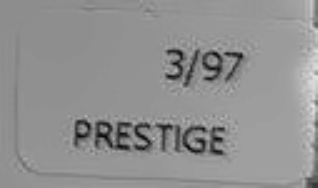

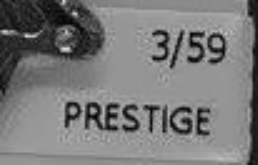

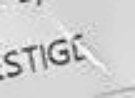

total weight: 7.5600000000000005


In [4]:
import cv2
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab.patches import cv2_imshow
import numpy as np
import easyocr
from scipy.ndimage import interpolation as inter
import pandas as pd
import re



reader = easyocr.Reader(['en'], gpu = False)
# Load the trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/image_processing/best.pt')



# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage


def detect_and_extract_text(image_path):
    # Load image
    img = cv2.imread(image_path)

    # Perform object detection
    results = model(image_path)

    # Extract bounding boxes
    detections = results.pandas().xyxy[0]  # Get pandas DataFrame of detections
    # print(detections)
    # Loop through detections
    total = 0
    for idx, row in detections.iterrows():
        # Extract bounding box coordinates and class
        xmin, ymin, xmax, ymax = map(int, [row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        label = row['name']

        cropped_img = img[ymin:ymax, xmin:xmax]

        (h, w) = cropped_img.shape[:2]
        cropped_img = cv2.fastNlMeansDenoisingColored(cropped_img, h=2)
        cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)


        if (h < 110 or w < 110):
          cropped_img = cv2.resize(cropped_img, None, fx=2.5, fy=2.5, interpolation=cv2.INTER_LINEAR)
        else:
          cropped_img = cv2.resize(cropped_img, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR)


        # deskewed_image = deskew(cropped_img)
        results = reader.readtext(cropped_img)
        x = pd.DataFrame(results, columns = ["bbox", "text", "confidence"])

        for i, r in x.iterrows():

          match1 = re.search(r'(\d+)/(\d+)\s+gr', r["text"])
          match2 = re.search(r'w:\s*(\d+)/(\d+)\s', r["text"])
          match3 = re.search(r'W:\s*(\d+)/(\d+)\s', r["text"])
          match4 = re.search(r'(\d+)/(\d+)', r["text"])

          match5 = re.search(r'(\d+)(\.)(\d+)\s+gr', r["text"])
          match6 = re.search(r'W:\s*(\d+)(\.)(\d+)', r["text"])
          match7 = re.search(r'w:\s*(\d+)(\.)(\d+)', r["text"])
          match8 = re.search(r'(.+)(\.)(.+)', r["text"])

          if match1:
            number = f"{match1.group(1)}.{match1.group(2)}"
            number = float(number)
            total += number
            print("match1",number)


          if match2:
            number = f"{match2.group(1)}.{match2.group(2)}"
            number = float(number)
            total += number
            print("match2",number)

          if match3:
            number = f"{match3.group(1)}.{match3.group(2)}"
            number = float(number)
            total += number
            print("match3",number)

          if match4:
            if match4.group(1).isdigit() and match4.group(2).isdigit():
              number = f"{match4.group(1)}.{match4.group(2)}"
              number = float(number)
              total += number

          if match5:
            if match5.group(1).isdigit() and match5.group(3).isdigit():
              f = re.findall('[-+]?(?:\d*\.*\d+)', r["text"])
              number = float(f[0])
              total += number

          if match6:
            if match6.group(1).isdigit() and match6.group(3).isdigit():
              f = re.findall('[-+]?(?:\d*\.*\d+)', r["text"])
              number = float(f[0])
              total += number

          if match7:
            if match7.group(1).isdigit() and match7.group(3).isdigit():
              f = re.findall('[-+]?(?:\d*\.*\d+)', r["text"])
              number = float(f[0])
              total += number

          if match8:
            if match8.group(1).isdigit() and match8.group(3).isdigit():
              f = re.findall('[-+]?(?:\d*\.*\d+)', r["text"])
              number = float(f[0])
              total += number

        plt.figure()
        cv2_imshow(cropped_img)
    print("total weight:", total)



# Path to your test image
image_path = '/content/1727281927590.jpg'

# Perform detection and text extraction
detect_and_extract_text(image_path)

Test the Yolo model for object detection

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-9-27 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


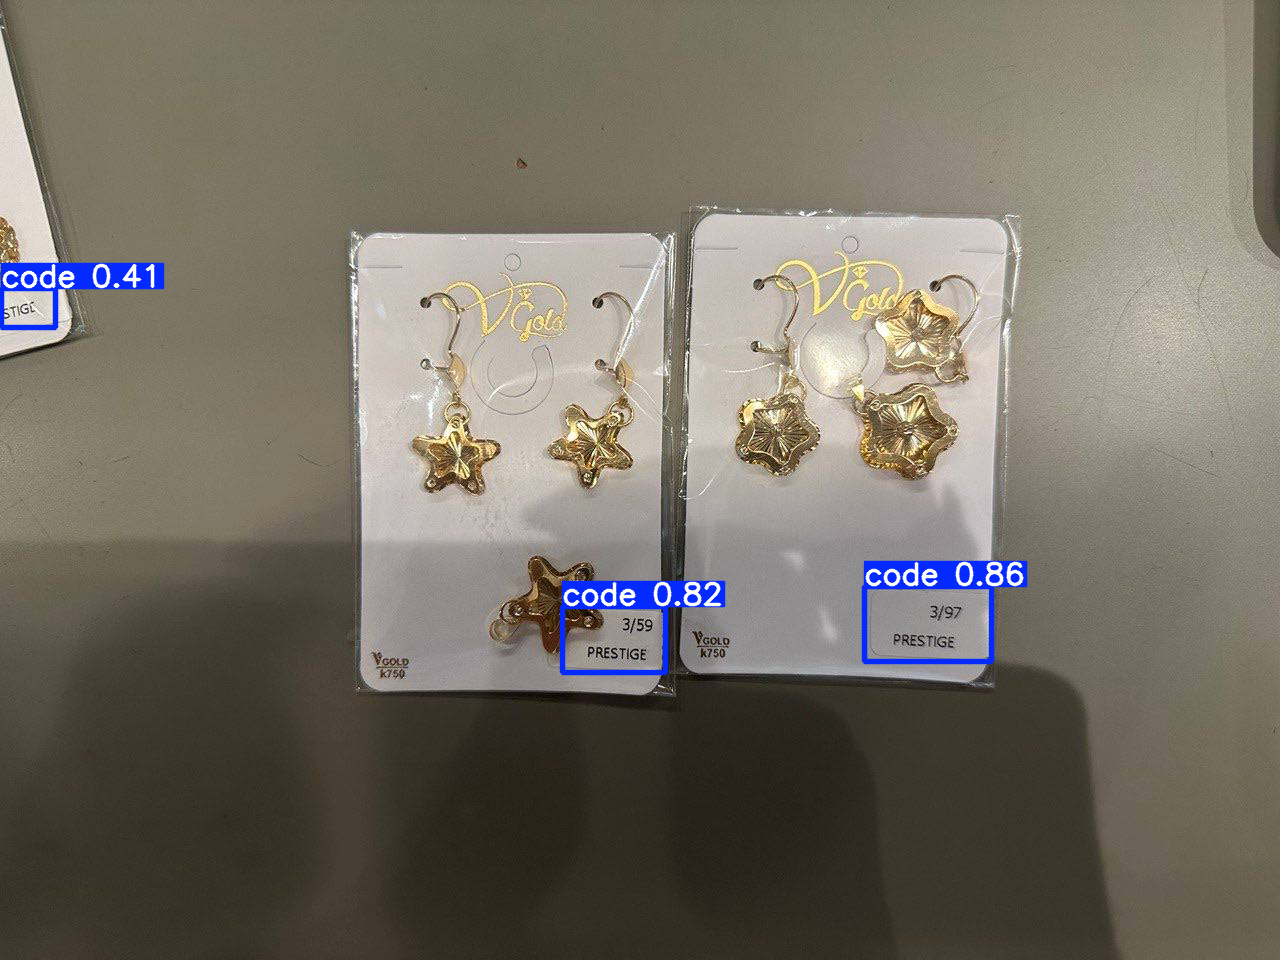

In [5]:
import torch
from pathlib import Path

model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/image_processing/best.pt')
img = Path('/content/1727281927590.jpg')  # Path to your test image
results = model(img)
results.show()